In [1]:
import meep as mp
import meep.adjoint as mpa
from meep import Animate2D
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from meep.materials import Ag
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
import matplotlib.colors as mcolors

mp.verbosity(1)
TiO2 = mp.Medium(index=2.6)
SiO2 = mp.Medium(index=1.44)
Si = mp.Medium(index=3.4)
Air = mp.Medium(index=1)

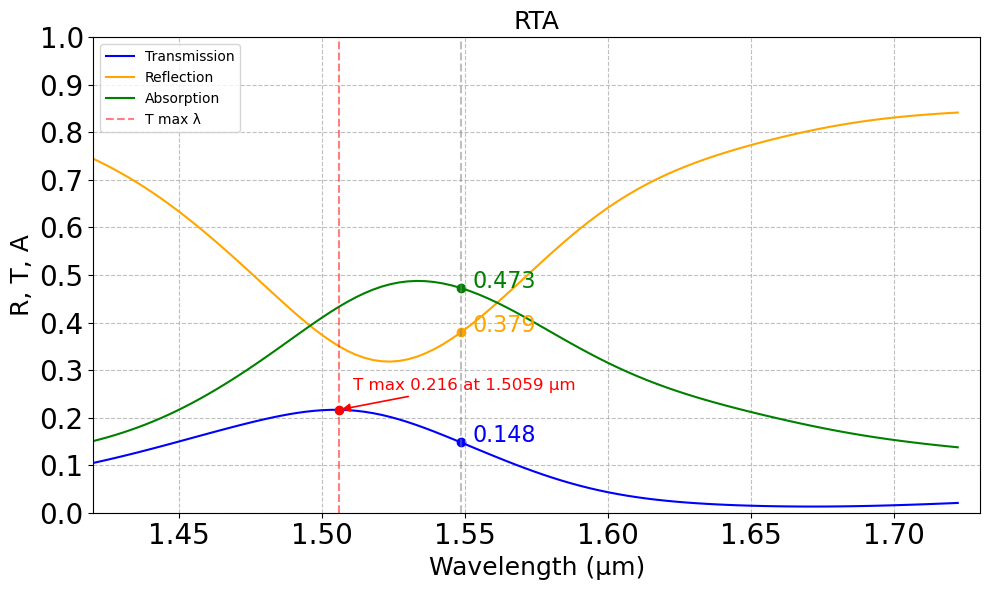

Closest to 1.55 µm -> λ=1.548436 µm, T=0.148093, R=0.379107, A=0.472800
Transmission maximum -> λ=1.505888 µm, T=0.216493


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# === 讀取資料 ===
trans_freqs        = np.load('TRAN/trans_freqs.npy')
trans_wavelengths  = np.load('TRAN/trans_wavelengths.npy')
trans_empty_fluxes = np.load('TRAN/trans_empty_fluxes.npy')
trans_fluxes       = np.load('TRAN/trans_fluxes.npy')
trans_final        = np.load('TRAN/trans_final.npy')  # T(λ)
ref_final          = np.load('TRAN/ref_final.npy')    # R(λ)
abs_final          = np.load('TRAN/abs_final.npy')    # A(λ)

# === 1) 取 1.55 μm 最接近點（保留 R/T/A）===
target_wavelength = 1.55
idx_155 = np.argmin(np.abs(trans_wavelengths - target_wavelength))
w_155 = trans_wavelengths[idx_155]
t_155 = trans_final[idx_155]
r_155 = ref_final[idx_155]
a_155 = abs_final[idx_155]

# === 2) 取 Transmission 最高點 ===
idx_tmax = np.argmax(trans_final)
w_tmax   = trans_wavelengths[idx_tmax]
t_tmax   = trans_final[idx_tmax]

# 小工具：在點旁邊畫註記（自動往內縮，避免超出座標框）
def annotate_point(ax, x, y, text, color='red', dy=12):
    xmin, xmax = ax.get_xlim()
    # 哪邊空間多就往哪邊放文字
    to_right = (x - xmin) < (xmax - x)
    dx = 10 if to_right else -10
    ha = 'left' if to_right else 'right'
    ax.annotate(
        text, xy=(x, y), xytext=(dx, dy), textcoords='offset points',
        ha=ha, va='bottom', color=color, fontsize=12,
        arrowprops=dict(arrowstyle='-|>', color=color, lw=1.2),
        clip_on=True
    )

# === 繪圖 ===
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(trans_wavelengths, trans_final, label='Transmission', color='blue')
ax.plot(trans_wavelengths, ref_final,   label='Reflection',   color='orange')
ax.plot(trans_wavelengths, abs_final,   label='Absorption',   color='green')

# 1.55 μm 標示（垂直線 + 三個點與數值）
ax.axvline(x=w_155, color='gray', linestyle='--', alpha=0.5)
ax.scatter(w_155, t_155, color='blue');   ax.text(w_155+0.004, t_155, f'{t_155:.3f}', color='blue',   fontsize=16)
ax.scatter(w_155, r_155, color='orange'); ax.text(w_155+0.004, r_155, f'{r_155:.3f}', color='orange', fontsize=16)
ax.scatter(w_155, a_155, color='green');  ax.text(w_155+0.004, a_155, f'{a_155:.3f}', color='green',  fontsize=16)

# Transmission 最高點：垂直線 + 點 + 註記（含波長與數值）
ax.axvline(x=w_tmax, color='red', linestyle='--', alpha=0.5, label='T max λ')
ax.scatter(w_tmax, t_tmax, color='red', zorder=5)
annotate_point(ax, w_tmax, t_tmax, f'T max {t_tmax:.3f} at {w_tmax:.4f} µm', color='red')

# 外觀
ax.set_xlabel('Wavelength (µm)', fontsize=18)
ax.set_ylabel('R, T, A', fontsize=18)
ax.set_title('RTA', fontsize=18)
ax.set_ylim(0, 1)
plt.yticks(np.arange(0, 1+0.000001 , 0.1), fontsize=1)
# 視需求固定範圍；或改成 ax.set_xlim(trans_wavelengths.min(), trans_wavelengths.max())
ax.set_xlim(1.42, 1.73)
ax.tick_params(labelsize=20)
ax.grid(True, linestyle='--', alpha=0.8)
ax.legend()

plt.tight_layout()
plt.show()

# 同步印出數值
print(f'Closest to 1.55 µm -> λ={w_155:.6f} µm, T={t_155:.6f}, R={r_155:.6f}, A={a_155:.6f}')
print(f'Transmission maximum -> λ={w_tmax:.6f} µm, T={t_tmax:.6f}')
